# Commuting to work in the Paris region 

In [1]:
from pynsee import *
import copy
import pandas as pd 
import numpy as np
import seaborn as sns
from shapely.geometry import Point
from pyvis.network import Network
from IPython.display import Markdown, display

files = get_file_list()
files_rp = (files
            .query("collection == 'RP'")
            .query("id.str.contains('RP_MOBP|RP_POP')")
            [['id', 'label']])

files_rp.to_csv('rp.csv')
files_rp

id                                              label
1309     RP_MOBPRO_2015  Données du Recensement de Population, table de...
1318     RP_MOBPRO_2016  Données du Recensement de Population, table de...
1327     RP_MOBPRO_2017  Données du Recensement de Population, table de...
1337     RP_MOBPRO_2018  Données du Recensement de Population, table de...
1346     RP_MOBPRO_2019  Données du Recensement de Population, table de...
1355     RP_MOBPRO_2020  Données du Recensement de Population, table de...
1365  RP_POP_LEGALE_COM  Populations légales des communes en vigueur au...

In [2]:
geodata_files = get_geodata_list()
geodata_files.to_csv('geodata_files.csv')

In [3]:
# download metadata 
col = get_column_metadata('RP_MOBPRO_2020')
col.to_csv('rp_col.csv')

col2 = col[['column', 'column_label_fr']].drop_duplicates()

Metadata for RP_MOBPRO_2020 has not been found, metadata for RP_MOBPRO_2016 is provided instead


In [4]:
# data on means of transport
display(col.query("column == 'TRANS'"))

dclt = (col
    .query("column == 'DCLT'")
    ['column_label_fr']
    .to_list())

print(f"{dclt=}")

column value                 value_label_fr  \
182  TRANS     1               Pas de transport   
183  TRANS     2                  Marche à pied   
184  TRANS     3                     Deux roues   
185  TRANS     4  Voiture, camion, fourgonnette   
186  TRANS     5           Transports en commun   
187  TRANS     Z                     Sans objet   

                                       column_label_fr  
182  Mode de transport principal le plus souvent ut...  
183  Mode de transport principal le plus souvent ut...  
184  Mode de transport principal le plus souvent ut...  
185  Mode de transport principal le plus souvent ut...  
186  Mode de transport principal le plus souvent ut...  
187  Mode de transport principal le plus souvent ut...

dclt=['Département, commune et arrondissement municipal (Paris,Lyon,Marseille) du lieu de travail']


In [5]:
# download data about workers commuting from home to work place
RP_MOBPRO_2020 = download_file('RP_MOBPRO_2020')
RP_MOBPRO_2020.head(3)

Extracting: 100%|██████████| 823M/823M [00:04<00:00, 173MB/s]  


COMMUNE    ARM  DCFLT   DCLT AGEREVQ CS1 DEROU DIPL EMPL ILT  ... REGION  \
0   01001  ZZZZZ  99999  01001     040   2     Z   16   21   1  ...     84   
1   01001  ZZZZZ  99999  01001     045   5     Z   14   16   1  ...     84   
2   01001  ZZZZZ  99999  01001     020   2     Z   14   21   1  ...     84   

  REGLT SEXE STAT STOCD TP TRANS TYPL TYPMR VOIT  
0    84    2   21    21  1     1    1    41    2  
1    84    2   10    22  2     5    2    12    1  
2    84    2   21    10  1     1    1    41    3  

[3 rows x 32 columns]

In [6]:
# download geographical data on commune and arrondissement
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')
arr = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:arrondissement_municipal')

In [7]:
# define communes metadata and colors
list_dep = ['75', '92', '94', '91', '93', '78',
             '95', '77']
list_dep_name = ['Paris', 'Hauts-de-Seine', 'Val-de-Marne', 'Essonne','Seine-Saint-Denis',
                 'Yvelines',
                  "Val d'Oise", 'Seine-et-Marne'
                ]

departement_idf_pattern = '|'.join(['^' + d for d in list_dep])

palette_colors = sns.color_palette("Set1").as_hex() + sns.color_palette("Set2").as_hex()

dfcolors_DCLT = pd.DataFrame({'DEP_DCLT': list_dep,
                              'color_DCLT': palette_colors[:len(list_dep)]})

dfcolors_COMMUNE = pd.DataFrame({'DEP_COMMUNE': list_dep,
                                 'color_COMMUNE': palette_colors[:len(list_dep)]})

display(Markdown('<br>'.join(
    f'<span style="font-family: monospace"> <span style="color: {palette_colors[c]}">████████</span> {list_dep_name[c]} </span>'
    for c in range(len(list_dep))
)))

<span style="font-family: monospace"> <span style="color: #e41a1c">████████</span> Paris </span><br><span style="font-family: monospace"> <span style="color: #377eb8">████████</span> Hauts-de-Seine </span><br><span style="font-family: monospace"> <span style="color: #4daf4a">████████</span> Val-de-Marne </span><br><span style="font-family: monospace"> <span style="color: #984ea3">████████</span> Essonne </span><br><span style="font-family: monospace"> <span style="color: #ff7f00">████████</span> Seine-Saint-Denis </span><br><span style="font-family: monospace"> <span style="color: #ffff33">████████</span> Yvelines </span><br><span style="font-family: monospace"> <span style="color: #a65628">████████</span> Val d'Oise </span><br><span style="font-family: monospace"> <span style="color: #f781bf">████████</span> Seine-et-Marne </span>

In [8]:
# coordinates of Notre Dame de Paris in epsg:3857
ndm_paris = Point(261502.2414969356, 6250007.719802492)

# compute distance to Paris for all cities
idfgeo = (pd.concat([
    (com
        .query("insee_reg == '11'")
        .query("insee_com != '75056'")
        [['insee_com', 'geometry', 'nom', 'population']]),
    (arr
        .query("insee_com.str.contains('^75')")
        .drop('insee_com', axis=1)
        .rename(columns={'insee_arm': 'insee_com'})
        [['insee_com', 'geometry', 'nom', 'population']])])
    .assign(center = lambda x: x['geometry'].apply(lambda y: y.centroid))
    .assign(distance_paris = lambda x: x['center'].apply(lambda y: ndm_paris.distance(y)))
    .sort_values('distance_paris', ascending=False)
    .reset_index(drop=True)
          )


In [9]:
idfgeo_com = idfgeo.drop(columns={'geometry', 'center'})
idfgeo_com.columns = ['COMMUNE', 'COMMUNE_NAME', 'COMMUNE_POP','distance_paris']

idfgeo_dclt = idfgeo_com.copy()
idfgeo_dclt.columns = ['DCLT', 'DCLT_NAME', 'DCLT_POP','distance_paris_DCLT']

In [10]:
# distances are measured with epsg 3857
# it may not reflect real distances
# hence, parameters are adjusted so that data captures only up to CDG airport
distance_paris_max = 40 * 1000

In [11]:
# data preparation from raw data
# only communes located less than 40km far from Paris are selected from Ile de France region
# only working places in Ile de France are kept

idfData = (RP_MOBPRO_2020  
           .query("REGION == '11'")
           .assign(COMMUNE = lambda x: np.where(x['COMMUNE'] == '75056', x['ARM'], x['COMMUNE']))
           .query("DCLT.str.contains(@departement_idf_pattern)")
           .assign(IPONDI = lambda x: x['IPONDI'].astype(float))           
           .groupby(['COMMUNE', 'DCLT'], as_index=False)
           .agg(IPONDI = ('IPONDI','sum'))                     
           .merge(idfgeo_com, on='COMMUNE', how='left')
           .merge(idfgeo_dclt, on='DCLT', how='left')
           .query("distance_paris <= @distance_paris_max")
           .query("distance_paris_DCLT <= @distance_paris_max")
           .assign(COMMUNE_POP = lambda x: pd.to_numeric(x['COMMUNE_POP']))   
           .assign(DCLT_POP = lambda x: pd.to_numeric(x['DCLT_POP']))   
           .assign(DEP_DCLT = lambda df: df['DCLT'].apply(lambda x: x[:2]))     
           .assign(DEP_COMMUNE = lambda df: df['COMMUNE'].apply(lambda x: x[:2]))   
           .assign(WORKER_TOT = lambda df: df.groupby('DCLT')['IPONDI'].transform('sum'))
           .sort_values('WORKER_TOT', ascending=False)              
           .reset_index(drop=True)
          )

ptot = sum((idfData
            [['COMMUNE', 'COMMUNE_POP']]
            .drop_duplicates()
            ['COMMUNE_POP']))
pondtot = sum(idfData['IPONDI'])

print(f'{ptot=}')
print(f'{pondtot=:.0f}')

display(idfData[idfData['COMMUNE'].str.contains('^75')].head(3))

ptot=9744647
pondtot=4204594


COMMUNE   DCLT       IPONDI              COMMUNE_NAME  COMMUNE_POP  \
1    75101  75115   198.684933  Paris 1er Arrondissement        16030   
11   75107  75115  1026.511137   Paris 7e Arrondissement        48520   
32   75119  75115  2378.153858  Paris 19e Arrondissement       183211   

    distance_paris                 DCLT_NAME  DCLT_POP  distance_paris_DCLT  \
1      2107.463834  Paris 15e Arrondissement    229472           6652.86722   
11     4142.781903  Paris 15e Arrondissement    229472           6652.86722   
32     6957.840029  Paris 15e Arrondissement    229472           6652.86722   

   DEP_DCLT DEP_COMMUNE     WORKER_TOT  
1        75          75  158675.267506  
11       75          75  158675.267506  
32       75          75  158675.267506

In [12]:
# threshold to define small cities in terms of population
ptot_threshold = 20000

# threshold defining flow of workers excluded from the visualisation
ipondi_threshold = 120

In [13]:
# if many people work in a city but few people live there 
# this city is not considered as 'small'
list_big_working_center = list((idfData
                        .query("WORKER_TOT >= @ptot_threshold")
                        ['DCLT']
                        .unique()
                          ))

smallCom = (idfData 
        .merge(idfgeo, right_on='insee_com', left_on='COMMUNE', how='left')
        .query("(COMMUNE_POP <= @ptot_threshold) and (COMMUNE not in @list_big_working_center)")  
        .reset_index(drop=True)
 )

ptot3 = sum(smallCom[['COMMUNE', 'COMMUNE_POP']].drop_duplicates()['COMMUNE_POP'])
pondtot3 = sum(smallCom['IPONDI'])

print(f"ptot {ptot3/ptot*100:.0f}%")
print(f"pondtot {pondtot3/pondtot*100:.0f}%")
print(f"pop range: {min(smallCom.COMMUNE_POP)} - {max(smallCom.COMMUNE_POP)}")
print(f"cities : {len(smallCom.COMMUNE.unique())}")
smallCom.head(5)


ptot 13%
pondtot 13%
pop range: 77 - 19943
cities : 171


COMMUNE   DCLT      IPONDI     COMMUNE_NAME  COMMUNE_POP  distance_paris_x  \
0   78372  75115  137.489593     Marly-le-Roi        16352      28751.099410   
1   78367  75115   21.554111     Mareil-Marly         3669      30679.439033   
2   95682  75115    5.105820  Villiers-le-Sec          193      37744.524377   
3   95678  75115    5.053693    Villiers-Adam          857      38724.378098   
4   78686  75115  407.381366         Viroflay        16744      21563.416164   

                  DCLT_NAME  DCLT_POP  distance_paris_DCLT DEP_DCLT  \
0  Paris 15e Arrondissement    229472           6652.86722       75   
1  Paris 15e Arrondissement    229472           6652.86722       75   
2  Paris 15e Arrondissement    229472           6652.86722       75   
3  Paris 15e Arrondissement    229472           6652.86722       75   
4  Paris 15e Arrondissement    229472           6652.86722       75   

  DEP_COMMUNE     WORKER_TOT insee_com  \
0          78  158675.267506     78372   
1          78  158675.267506     78367   
2          95  158675.267506     95682   
3          95  158675.267506     95678   
4          78  158675.267506     78686   

                                            geometry              nom  \
0  MULTIPOLYGON (((231328.42141112 6253478.413274...     Marly-le-Roi   
1  MULTIPOLYGON (((232007.36266255 6254301.201724...     Mareil-Marly   
2  MULTIPOLYGON (((266744.03698707 6289583.072410...  Villiers-le-Sec   
3  MULTIPOLYGON (((253130.560195 6287866.69944999...    Villiers-Adam   
4  MULTIPOLYGON (((240592.31554645 6243153.844997...         Viroflay   

   population                                         center  distance_paris_y  
0       16352  POINT (232819.32891271802 6251986.6697672615)      28751.099410  
1        3669    POINT (231170.9966398288 6254616.793980174)      30679.439033  
2         193   POINT (265674.50005788024 6287520.935859931)      37744.524377  
3         857     POINT (249213.191462859 6286730.419979663)      38724.378098  
4       16744   POINT (241709.96463572598 6241449.291599193)      21563.416164

In [14]:
# regroup small cities if they are next to one another and if they are in the same departement
# the ones left behind are regrouped by departement

list_com_group = {}

list_com = list(smallCom['COMMUNE'].unique())

list_city_grouped = []

for c in list_com:

    if c not in list_city_grouped:

        com = smallCom.query("COMMUNE == @c").reset_index(drop=True)
        
        dep = com['DEP_COMMUNE'][0]
        
        geo = com['geometry'][0]
        
        comDep = (smallCom
                  .query("(DEP_COMMUNE == @dep) and (COMMUNE != @c)")
                  [['COMMUNE', 'geometry', 'COMMUNE_NAME']]
                  .drop_duplicates())
        
        list_com_group[c] = [i for i, g in zip(list(comDep['COMMUNE']),
                                              list(comDep['geometry']))
                                if (g.intersects(geo)) and (i not in list_city_grouped)]
        
        list_city_grouped += list_com_group[c] + [c]

list_com_group_alone = [k for k in list_com_group.keys() if len(list_com_group[k]) == 0]

list_com_dep_missing = list(set([k[:2] for k in list_com_group_alone]))

list_com_group_missing = {}

for d in list_com_dep_missing:
    list_com_group_missing[d] = [k for k in list_com_group_alone if d == k[:2]]
    if len(list_com_group_missing[d]) > 1:
        first = list_com_group_missing[d][0]
        list_com_group_missing[first] = list_com_group_missing[d][1:]
        del list_com_group_missing[d]
    else:
        first = list_com_group_missing[d][0]
        list_com_group_missing[first] = []
        del list_com_group_missing[d]
        
list_com_group_final = {**{k:list_com_group[k] 
                               for k in list_com_group.keys() if len(list_com_group[k]) != 0},
                        **list_com_group_missing}

dict_small_cities = {k2: k for k in list_com_group_final.keys() for k2 in list_com_group_final[k]}
dict_small_cities = {**dict_small_cities, **{k: k for k in list_com_group_final.keys()}}


In [15]:
smallComRegrouped_list = []
for k in list_com_group_final.keys():
    comGroup = list_com_group_final[k] + [k]
    smallComR = (smallCom
                 .query("COMMUNE in @comGroup")
                 .query("DCLT not in @comGroup")
                 .sort_values('COMMUNE_POP', ascending=False)
                )
    new_name = '\n'.join(list(smallComR['COMMUNE_NAME'].unique()))
    smallComR.loc[:, 'COMMUNE_NAME'] = new_name
    smallComR.loc[:, 'COMMUNE'] = k
    smallComRegrouped_list += [smallComR]

small_cities = pd.concat(smallComRegrouped_list)

ptot_small = (small_cities
              [['COMMUNE', 'COMMUNE_POP']]
             .drop_duplicates()
             .groupby(['COMMUNE'], as_index=False)
             .agg(COMMUNE_POP = ('COMMUNE_POP', 'sum')))

smallComRegrouped = (small_cities
                     .groupby(['COMMUNE', 'DCLT',
                               'COMMUNE_NAME', 'DCLT_NAME', 
                               'DEP_COMMUNE', 'DEP_DCLT'], as_index=False)
                     .agg(IPONDI = ('IPONDI', 'sum'))
                     .merge(ptot_small, on='COMMUNE', how='left')
                    )

small_cities_mapping_name = (small_cities[['COMMUNE', 'COMMUNE_NAME']]
                             .drop_duplicates())
                             
small_cities_name = dict(zip(small_cities_mapping_name['COMMUNE'],
                                 small_cities_mapping_name['COMMUNE_NAME']))

small_cities_pop = dict(zip(ptot_small['COMMUNE'],
                                       ptot_small['COMMUNE_POP']))

def replace_small_cities_name(ident, name):    
    if ident in small_cities_name.keys():
        new_name = small_cities_name[ident]
    else:
        new_name = name
    return new_name
    
def replace_small_cities_pop(ident, pop):    
    if ident in small_cities_pop.keys():
        new_pop = small_cities_pop[ident]
    else:
        new_pop = pop
    return new_pop

In [16]:
bigCities = (idfData 
        .query("(COMMUNE_POP > @ptot_threshold) or (COMMUNE in @list_big_working_center)")   
             )
             
ptot2 = sum(bigCities[['COMMUNE', 'COMMUNE_POP']].drop_duplicates()['COMMUNE_POP'])
pondtot2 = sum(bigCities['IPONDI'])

print(f"ptot {ptot2/ptot*100:.0f}%")
print(f"pondtot {pondtot2/pondtot*100:.0f}%")

ptot 87%
pondtot 87%


In [17]:
list_col_group = ['COMMUNE', 'DCLT', 
                'COMMUNE_NAME', 'DCLT_NAME', 
                'DEP_COMMUNE', 'DEP_DCLT',                 
                'COMMUNE_POP']

idfData2 = (pd.concat([bigCities, smallComRegrouped]) 
        .query("DCLT != COMMUNE")
        .assign(DCLT = lambda x: x['DCLT'].apply(
                lambda y: dict_small_cities[y] if y in dict_small_cities.keys() else y
            ))
        .assign(DCLT_NAME = lambda x:
                x[['DCLT', 'DCLT_NAME']].apply(
                    lambda y: replace_small_cities_name(*y), axis=1
            ))
        .apply(lambda c: c.astype(str) if c.name in list_col_group else c)
        .groupby(list_col_group, as_index=False)
        .agg(IPONDI = ('IPONDI', 'sum'))
        .assign(COMMUNE_POP = lambda x: pd.to_numeric(x['COMMUNE_POP']))            
        .reset_index(drop=True)
        .merge(dfcolors_DCLT, on = 'DEP_DCLT', how='left')
        .merge(dfcolors_COMMUNE, on = 'DEP_COMMUNE', how='left')
        .sort_values(['COMMUNE_POP'], ascending=False)        
        .merge(idfgeo_dclt[['DCLT', 'DCLT_POP']], on='DCLT', how='left')
        .assign(DCLT_POP = lambda x:
                x[['DCLT', 'DCLT_POP']].apply(
                    lambda y: replace_small_cities_pop(*y), axis=1
            ))
           )

print(' ')
ptot2 = sum(idfData2[['COMMUNE', 'COMMUNE_POP']].drop_duplicates()['COMMUNE_POP'])
pondtot2 = sum(idfData2['IPONDI'])

print(f"ptot {ptot2/ptot*100:.0f}%")
print(f"pondtot {pondtot2/pondtot*100:.0f}%")
print(f"pop range: {min(idfData2.COMMUNE_POP)} - {max(idfData2.COMMUNE_POP)}")
print(f"cities : {len(idfData2.COMMUNE.unique())}")

display(idfData2.head(5))

 
ptot 100%
pondtot 75%
pop range: 385 - 229472
cities : 227


COMMUNE   DCLT              COMMUNE_NAME  \
0   75115  95582  Paris 15e Arrondissement   
1   75115  91339  Paris 15e Arrondissement   
2   75115  91345  Paris 15e Arrondissement   
3   75115  78686  Paris 15e Arrondissement   
4   75115  91064  Paris 15e Arrondissement   

                                           DCLT_NAME DEP_COMMUNE DEP_DCLT  \
0                                            Sannois          75       95   
1                                   Montlhéry\nLinas          75       91   
2                                         Longjumeau          75       91   
3                                Viroflay\nAigremont          75       78   
4  Verrières-le-Buisson\nIgny\nBièvres\nSaclay\nV...          75       91   

   COMMUNE_POP      IPONDI color_DCLT color_COMMUNE  DCLT_POP  
0       229472   10.680057    #a65628       #e41a1c     26524  
1       229472   28.824383    #984ea3       #e41a1c     15425  
2       229472   24.813545    #984ea3       #e41a1c     21105  
3       229472   39.697347    #ffff33       #e41a1c     17829  
4       229472  169.085663    #984ea3       #e41a1c     35870

In [18]:
# compute statistics on where workers work in percentage by city

working_place_ranking = (
     idfData2
     .groupby(['DCLT', 'DCLT_NAME', 'DEP_DCLT'], as_index=False)
     .agg(IPONDI = ('IPONDI', 'sum'), DCLT_POP = ('DCLT_POP', 'min'))
     .assign(pct_worker0 = lambda x: x['IPONDI'] * 100 / sum(x['IPONDI']))
     .assign(pct_worker = lambda x: x['pct_worker0'].apply(lambda y: str(round(y, 2)) + '%'))
     .assign(pct_pop0 = lambda x: x['DCLT_POP'] * 100 / sum(x['DCLT_POP']))
     .assign(pct_pop = lambda x: x['pct_pop0'].apply(lambda y: str(round(y, 2)) + '%'))
     .sort_values('pct_worker', ascending=False)
     .reset_index(drop=True)
     .assign(working_place_ranking = lambda x: x.index + 1)
     .rename(columns = {'DCLT' : 'COMMUNE'})
     .drop(columns = {'IPONDI'})
)
working_place_ranking.head(10)

COMMUNE                 DCLT_NAME DEP_DCLT  DCLT_POP  pct_worker0  \
0   75108   Paris 8e Arrondissement       75     35631     4.732278   
1   75115  Paris 15e Arrondissement       75    229472     3.851695   
2   75109   Paris 9e Arrondissement       75     60168     2.954503   
3   75113  Paris 13e Arrondissement       75    177833     2.663345   
4   75112  Paris 12e Arrondissement       75    140311     2.589525   
5   92026                Courbevoie       92     82074     2.401820   
6   75116  Paris 16e Arrondissement       75    162820     2.396540   
7   75117  Paris 17e Arrondissement       75    166336     2.219577   
8   92062                   Puteaux       92     44009     2.003127   
9   92012      Boulogne-Billancourt       92    120911     1.967958   

  pct_worker  pct_pop0 pct_pop  working_place_ranking  
0      4.73%  0.365647   0.37%                      1  
1      3.85%  2.354852   2.35%                      2  
2      2.95%  0.617447   0.62%                      3  
3      2.66%  1.824930   1.82%                      4  
4      2.59%  1.439878   1.44%                      5  
5       2.4%  0.842247   0.84%                      6  
6       2.4%  1.670866   1.67%                      7  
7      2.22%  1.706947   1.71%                      8  
8       2.0%  0.451622   0.45%                      9  
9      1.97%  1.240794   1.24%                     10

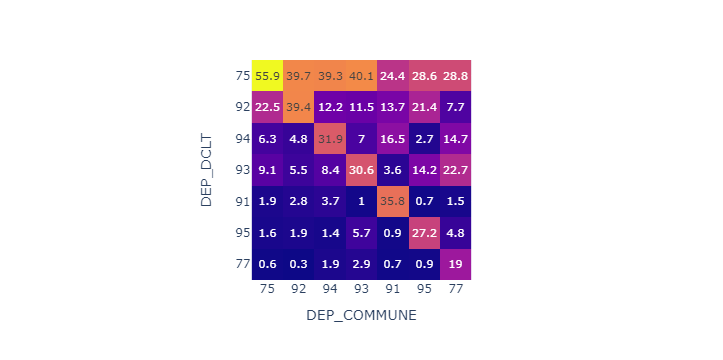

In [19]:
# compute statistics on where workers work in percentage by departement

list_dep_ordered = ['75', '92', '94', '93', '91', '95', '77']

working_dep_ranking = (
    idfData2
    .groupby(['DEP_COMMUNE', 'DEP_DCLT'], as_index=False)
    .agg(IPONDI = ('IPONDI', 'sum'))
    .assign(POND_COM = lambda x: x.groupby(['DEP_COMMUNE'])['IPONDI'].transform('sum'))
    .assign(pct = lambda x: round(100 * x['IPONDI'] / x['POND_COM'], 1))
    .pivot(index=['DEP_DCLT'], columns=['DEP_COMMUNE'], values = 'pct')
    .reindex(list_dep_ordered)  
    [list_dep_ordered]
)

import plotly.express as px

fig = (px.imshow(working_dep_ranking,
                text_auto=True)       
      )
fig.layout.coloraxis.showscale = False

fig

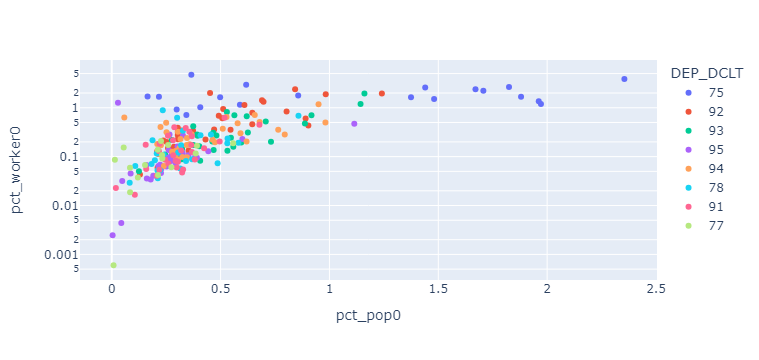

In [20]:
import plotly.express as px
fig = px.scatter(working_place_ranking,
                 x="pct_pop0", y="pct_worker0", color="DEP_DCLT",
                 log_y=True,
                 hover_data=['DCLT_NAME'])
fig

In [21]:
# create nodes dataframe for the network visualisation

# we remove small workers flow to make the plot clearer
idfData3 = idfData2.query("IPONDI > @ipondi_threshold")

list_com = list(idfData3['COMMUNE'].unique()) + list(idfData3['DCLT'].unique())

all_cities = pd.concat([idfData3
                        [['COMMUNE', 'COMMUNE_NAME', 'color_COMMUNE', 'COMMUNE_POP']],
               (idfData3
                [['DCLT', 'DCLT_NAME', 'color_DCLT', 'DCLT_POP']]
                .rename(columns= {'DCLT': 'COMMUNE',
                                 'DCLT_NAME': 'COMMUNE_NAME',
                                 'DCLT_POP': 'COMMUNE_POP',
                                 'color_DCLT': 'color_COMMUNE'}))
              ])

list_nodes = (all_cities
              .query("COMMUNE in @list_com")
              .apply(lambda c: c.astype(str) if c.name != 'COMMUNE_POP' else c.astype(float))
              .drop_duplicates()
              .merge(working_place_ranking, on ='COMMUNE', how='left')
              .assign(COMMUNE_NAME = lambda x: x.apply(
                  lambda y: y['COMMUNE_NAME'] + '\n' +
                  'departement: '+ str(y['DEP_DCLT']) + '\n' +                  
                  'working place ranking: '+ str(y['working_place_ranking']) + '\n' +
                  'percentage of population: '+ str(y['pct_pop']) + '\n' +
                  'percentage of workers: '+ str(y['pct_worker']), axis=1))
             )

list_nodes.to_csv('network_nodes.csv')
idfData3.to_csv('network_edges.csv')

In [28]:
# create network visualization

net = Network(
    notebook=True,
)
net.width = '1900px'
net.height = '1068.75px'
#net.width = '800px'
#net.height = '500px'

for ident, name, color, ptot in zip(list(list_nodes['COMMUNE']),
                       list(list_nodes['COMMUNE_NAME']),
                       list(list_nodes['color_COMMUNE']),
                       list(list_nodes['COMMUNE_POP'])):
    net.add_node(ident, label = name, color=color, value=ptot, title=name)

for ident1, ident2, size, color in zip(list(idfData3['COMMUNE']),
                                list(idfData3['DCLT']),
                                list(idfData3['IPONDI']),
                                list(idfData3['color_DCLT'])
                               ):
    net.add_edge(ident1, ident2, value=size, color=color)

net.force_atlas_2based()

filename = 'commute_paris_network.html'
net.save_graph(filename)
#net.show(filename)

In [32]:
import os
os.chdir('/home/onyxia/work/pynsee/docs/_static')

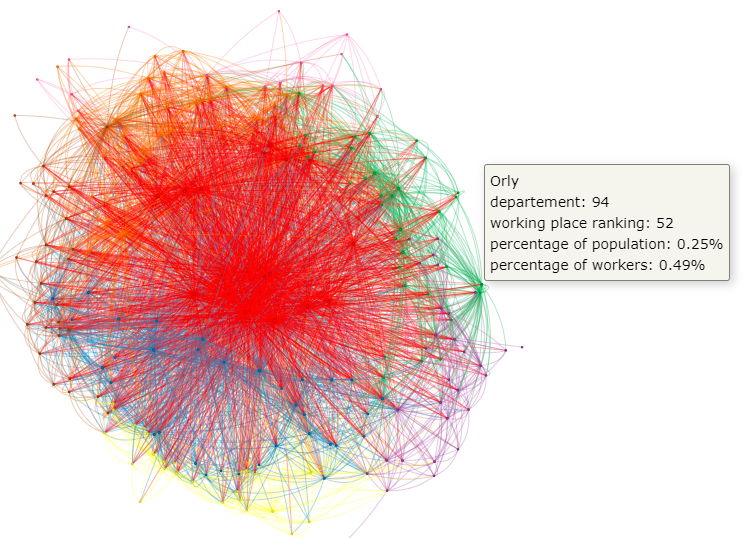

In [34]:
from PIL import Image
Image.open('commute_paris.png').convert("RGB")